In [1]:
import numpy as np
np.random.seed(42)
import pandas as pd
from pandas import DataFrame

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
import graphviz

import scikitplot as skplt
import matplotlib
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel(r'C:\Users\Zlatana.Nenova\OneDrive - University of Denver\Documents\DU\DU Quarters\Fall 2020\INFO 4300\Week 5\Class 2\Problems\CatalogSales.xlsx')
data.shape

(2000, 9)

In [3]:
data.head()

,US(YN),Freq,last_update_days_ago,1st_update_days_ago,Web order,Gender(Male),Address_is_res(YN),Purchase(YN),PurchaseAmt
0,1,2,3662,3662,1,0,1,1,88.47
1,1,0,2900,2900,1,1,0,0,0.00
2,1,2,3883,3914,0,0,0,1,87.48
3,1,1,829,829,0,1,0,0,0.00
4,1,1,869,869,0,0,0,0,0.00


In [4]:
#rename columns to more friendly names
data.rename(columns={'Gender(Male)':'Male','US(YN)':'US','Web order':'Web_order',
                     'Address_is_res(YN)':'Res_address','Purchase(YN)':'Purchase'},inplace=True)
data.Purchase.replace({1: 'Yes',0: 'No'},inplace=True)

## Classification Tree

In [5]:
np.random.seed(42)
train, test = train_test_split(data, test_size=0.4, random_state=42,stratify=data.Purchase)
print(len(train), "train +", len(test), "test")

1200 train + 800 test


In [6]:
X1_train = train.drop(columns=['Purchase','PurchaseAmt'])
Y1_train = DataFrame(train['Purchase'],columns=['Purchase'])
X1_test = test.drop(columns=['Purchase','PurchaseAmt'])
Y1_test = DataFrame(test['Purchase'],columns=['Purchase'])

In [7]:
parent_size = int(len(train)*.02)
clf = DecisionTreeClassifier(max_depth=5,min_samples_split=parent_size,min_weight_fraction_leaf =.01,min_impurity_decrease=.005)
clf = clf.fit(X1_train, Y1_train)

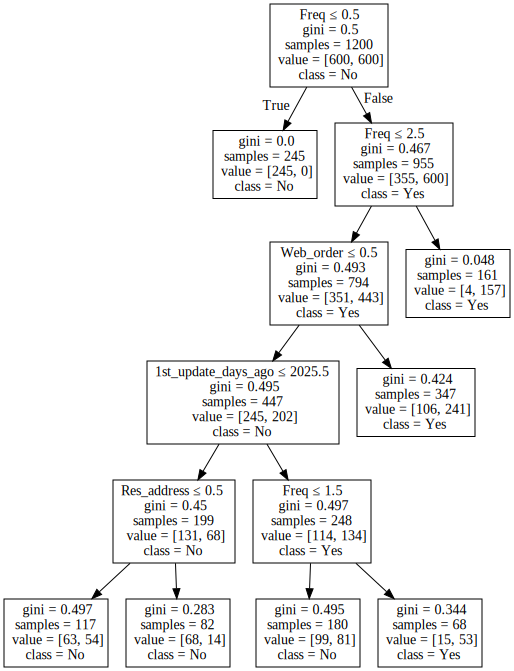

In [8]:
dt_data = export_graphviz(clf, out_file=None, feature_names=X1_train.columns,
                          class_names=sorted(Y1_train.Purchase.unique()),
                         special_characters=True)
graphviz.Source(dt_data)

#### All Data Confusion Matrix & Accuracy

In [9]:
pred_all_target = DataFrame(clf.predict(data.drop(columns=['Purchase','PurchaseAmt'])),index=data.index,columns=['Predicted'])
matrix = pd.merge(pred_all_target,data,left_index=True,right_index=True)
pd.crosstab(matrix.Purchase,matrix.Predicted)

Predicted,No,Yes
Purchase,,
No,768,232
Yes,246,754


In [10]:
#manual calculation
(1 - (len(matrix.loc[(matrix.Predicted=='Yes') & (matrix.Purchase=='No')])+
 len(matrix.loc[(matrix.Predicted=='No') & (matrix.Purchase=='Yes')]))/len(matrix))*100

76.1

In [11]:
#accuracy score
accuracy_score(matrix.Purchase,matrix.Predicted)*100

76.1

#### Training Data Confusion Matrix & Accuracy

In [12]:
pred_train_target = DataFrame(clf.predict(X1_train),index=X1_train.index,columns=['Predicted'])
train_matrix = pd.merge(pred_train_target,Y1_train,left_index=True,right_index=True)
pd.crosstab(train_matrix.Purchase,train_matrix.Predicted)

Predicted,No,Yes
Purchase,,
No,475,125
Yes,149,451


In [13]:
(accuracy_score(train_matrix.Purchase,train_matrix.Predicted)*100).round(2)

77.17

#### Testing Data Confusion Matrix & Accuracy

In [14]:
pred_test_target = DataFrame(clf.predict(X1_test),index=X1_test.index,columns=['Predicted'])
test_matrix = pd.merge(pred_test_target,Y1_test,left_index=True,right_index=True)
pd.crosstab(test_matrix.Purchase,test_matrix.Predicted)

Predicted,No,Yes
Purchase,,
No,293,107
Yes,97,303


In [15]:
accuracy_score(test_matrix.Purchase,test_matrix.Predicted)*100

74.5

## Evaluation Methods

Gains Chart

In [16]:
y_probas = clf.predict_proba(X1_train)
y_test_probas = clf.predict_proba(X1_test)

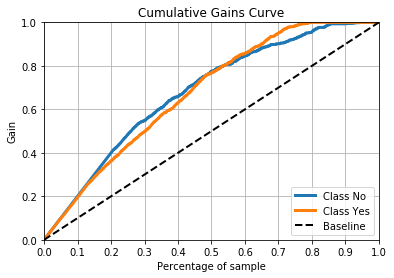

In [17]:
fig = skplt.metrics.plot_cumulative_gain(Y1_train, y_probas)
plt.setp(fig,xticks=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
plt.show()

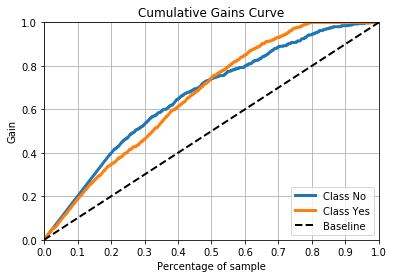

In [18]:
fig = skplt.metrics.plot_cumulative_gain(Y1_test, y_test_probas)
plt.setp(fig,xticks=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
plt.show()

Lift Curve

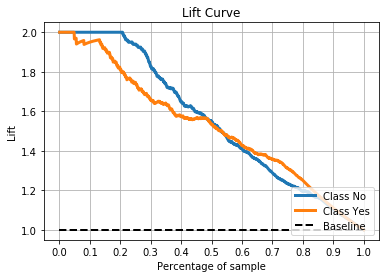

In [19]:
lift = skplt.metrics.plot_lift_curve(Y1_train, y_probas)
plt.setp(lift,xticks=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
plt.show()

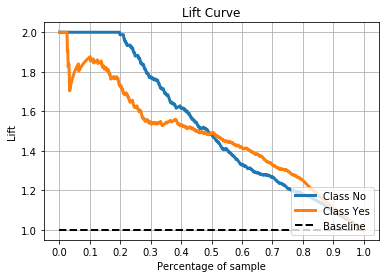

In [20]:
lift = skplt.metrics.plot_lift_curve(Y1_test, y_test_probas)
plt.setp(lift,xticks=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
plt.show()

ROC Curve

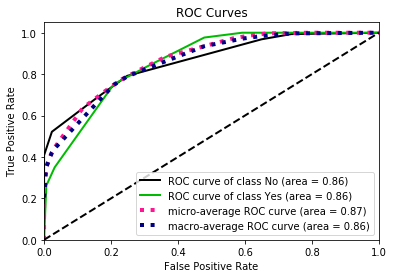

In [21]:
skplt.metrics.plot_roc(Y1_train, y_probas)
plt.show()

In [22]:
roc_auc_score(DataFrame(Y1_train).replace(['Yes','No'],[1,0]), DataFrame(y_probas).loc[:,1]).round(2)

0.86

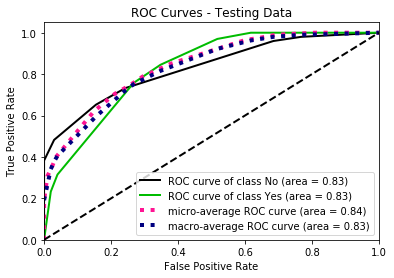

In [23]:
y_test_probas = clf.predict_proba(X1_test)
skplt.metrics.plot_roc(Y1_test, y_test_probas,title='ROC Curves - Testing Data')
plt.show()

In [24]:
roc_auc_score(DataFrame(Y1_test).replace(['Yes','No'],[1,0]), DataFrame(y_test_probas).loc[:,1]).round(2)

0.83